<a href="https://colab.research.google.com/github/ria-heikkila/fish_species_recognizer/blob/master/fish_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
from tensorflow.python.keras.applications.vgg16 import VGG16

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
image_size = 150
num_classes = 2

In [30]:
#モデル定義
model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [31]:
#trainableレイヤー定義

top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(BatchNormalization())
top_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=model.input, outputs=top_model(model.output))

for layer in model.layers[:15]:
  layer.trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [0]:
#モデルのコンパイル
model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
#データの準備
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "./drive/My Drive/data_fish/train"
validate_dir = "./drive/My Drive/data_fish/validate"
batch_size = 16

#Training Set
train_set = train_datagen.flow_from_directory(train_dir,
                                             target_size=(image_size,image_size),
                                             batch_size=batch_size,
                                             class_mode='binary')
#Validation Set
test_set = test_datagen.flow_from_directory(validate_dir,
                                           target_size=(image_size,image_size),
                                           batch_size =batch_size,
                                           class_mode='binary',
                                           shuffle=False)

Found 200 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [34]:
#トレーニング
history = model.fit_generator(
        train_set,
        steps_per_epoch=200 // batch_size,
        epochs=10,
        validation_data=test_set,
        validation_steps=80 // batch_size)
model.save('fish_model.h5')

Epoch 1/10
12/12 [==============================] - 6s 498ms/step - loss: 0.8580 - accuracy: 0.4891 - val_loss: 0.9127 - val_accuracy: 0.3750
Epoch 2/10
12/12 [==============================] - 6s 495ms/step - loss: 0.6528 - accuracy: 0.6141 - val_loss: 0.6853 - val_accuracy: 0.4125
Epoch 3/10
12/12 [==============================] - 6s 486ms/step - loss: 0.4588 - accuracy: 0.8152 - val_loss: 0.5340 - val_accuracy: 0.7375
Epoch 4/10
12/12 [==============================] - 6s 481ms/step - loss: 0.4263 - accuracy: 0.7989 - val_loss: 0.4246 - val_accuracy: 0.8750
Epoch 5/10
12/12 [==============================] - 6s 493ms/step - loss: 0.3933 - accuracy: 0.8152 - val_loss: 0.3489 - val_accuracy: 0.9250
Epoch 6/10
12/12 [==============================] - 6s 482ms/step - loss: 0.3113 - accuracy: 0.8913 - val_loss: 0.3112 - val_accuracy: 0.9250
Epoch 7/10
12/12 [==============================] - 6s 499ms/step - loss: 0.3229 - accuracy: 0.8587 - val_loss: 0.2684 - val_accuracy: 0.9375
Epoch 

In [35]:
test_loss, test_acc = model.evaluate_generator(test_set, steps=80)
print('test loss:', test_loss)
print('test acc:', test_acc)

test loss: 0.19212499260902405
test acc: 0.9624999761581421


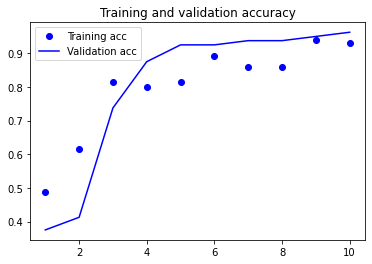

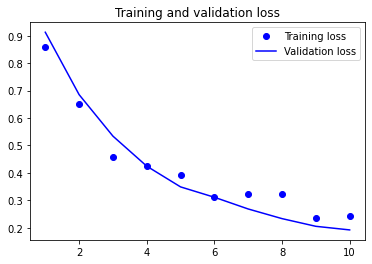

In [36]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

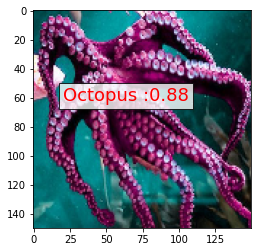

In [39]:
#画像多数の予測
%matplotlib inline
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
img1 = image.load_img('7.jpg', target_size=(image_size, image_size))
img = image.img_to_array(img1)
img = img/255.0
# create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)
prediction = model.predict(img, batch_size=None,steps=1) #gives all class prob.
if(prediction[:,:]>0.5):
    value ='Squid :%1.2f'%(prediction[0,0])
    plt.text(20, 62,value,color='blue',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
else:
    value ='Octopus :%1.2f'%(1.0-prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))

plt.imshow(img1)
plt.show()

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


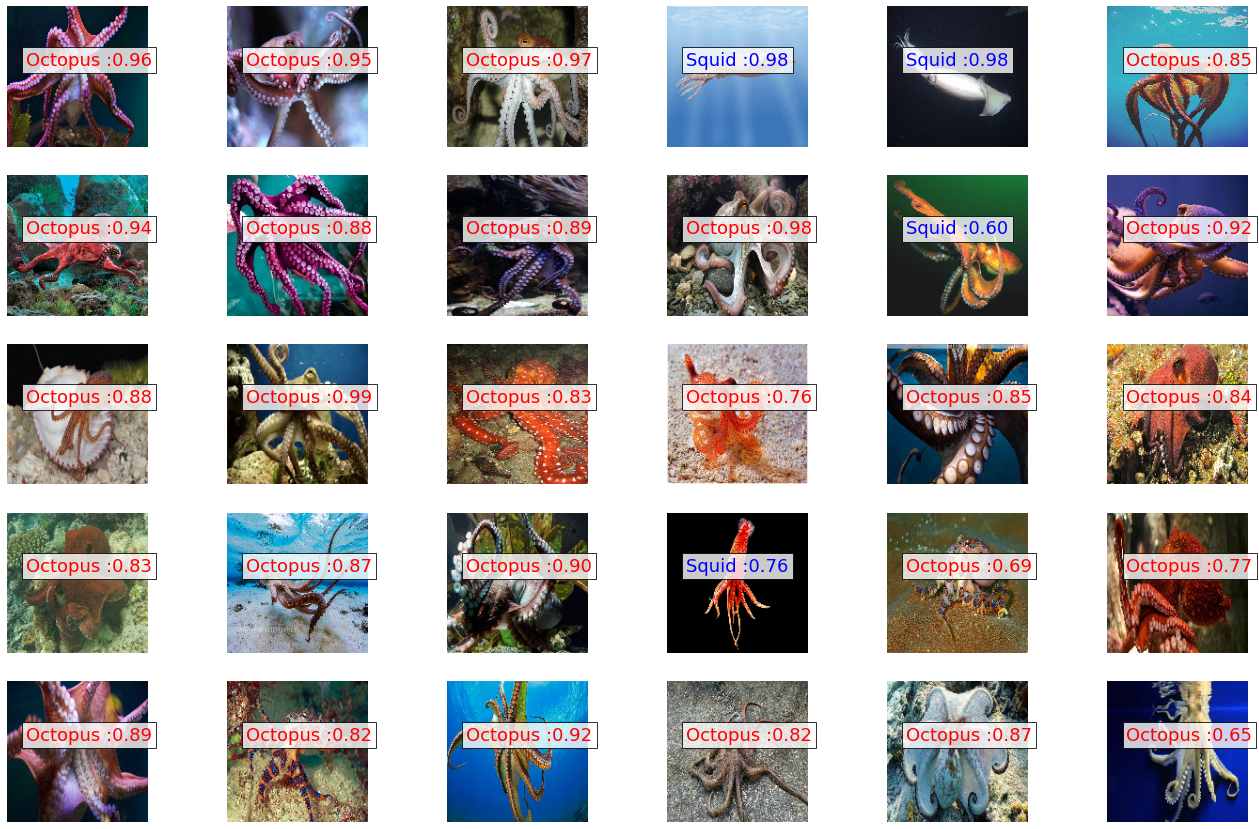

In [40]:
#画像多数の予測
fig=plt.figure(figsize=(23, 15))
columns = 6
rows = 5
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img1 = image.load_img(str(i) + ".jpg", target_size=(image_size, image_size))
    img = image.img_to_array(img1)
    img = img/255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img, batch_size=None,steps=1) #gives all class prob.
    if(prediction[:,:]>0.5):
      value ='Squid :%1.2f'%(prediction[0,0])
      plt.text(20, 62,value,color='blue',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
      plt.axis("off")
    else:
      value ='Octopus :%1.2f'%(1.0-prediction[0,0])
      plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
      plt.axis("off")
    plt.imshow(img1)